In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Concatenate, Dense, Dropout
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
%matplotlib inline


movies_df = pd.read_csv('../../dataset/MovieLens_files/movies_curated.csv')
ratings = pd.read_csv('../../dataset/MovieLens_files/ratings_with_title.csv')


In [38]:
# The user/movie fields are currently sequential integers representing some unique ID for that entity. 
# We need them to be sequential starting at zero to use for modeling (right now, the userId starts at 1 and needs to starts at 0). We use scikit-learn's LabelEnconcer to transform the fields.
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)

# We’ll also create variables with the total number of unique users and movies in the data, 
#as well as the min and max ratings present in the data, for reasons that will become apparent shortly.
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(138493, 26744, 0.5, 5.0)

In [5]:
# Splitting the data

X = ratings[['user', 'movie']].values

# What we want to know
y = ratings['rating'].values
X_train, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, X_test.shape, y_train_full.shape, y_test.shape)
print(X)

(18000236, 2) (2000027, 2) (18000236,) (2000027,)
[[     0      1]
 [     4      1]
 [    12      1]
 ...
 [138300  25231]
 [138405  22980]
 [138405  23071]]


In [ ]:
print(y)

In [6]:
# Another constant we’ll need for the model is the number of factors per user/movie. 
# This number can be whatever we want, however for the collaborative filtering model it does need to be the same size for both users and movies.
n_factors = 50

# Finally, we need to turn users and movies into separate arrays in the training and test data.
# This is because in Keras they’ll each be defined as distinct inputs, and the way Keras works is each input needs to be fed in as its own array.
full_X_train_array = [X_train[:, 0], X_train[:, 1]]
full_X_test_array = [X_test[:, 0], X_test[:, 1]]

X_train = [full_X_train_array[0][9000118:],full_X_train_array[1][9000118:]]
y_train = y_train_full[9000118:] 
X_valid = [full_X_train_array[0][:9000118],full_X_train_array[1][:9000118]]
y_valid = y_train_full[:9000118]

In [ ]:
# As we can see, X_train_array is a list with two arrays: one with users, the other with movies
full_X_train_array[0].shape
full_X_train_array[1].shape

In [196]:
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    """
    Returns the model that can predict user ratings for different films
    
    Parameters
    ----------
    n_users : int 
        number of unique users in the database
        
    n_movies : int 
        number of unique movies in the database
        
    n_factors : int
        number of factors per user/movie we want to have. It is the same size for movies and users
        
    min_rating : int 
        minimum rating a user can give a film
        
    max_rating : int 
        maximum rating a user can give a film

    Returns
    ----------
    model : tensorflow.python.keras.engine.functional.Functional
        The tensorflow/keras model is returned
    
    """
    
    # Initiate a Keras tensor
    # Allows us to use users (in this case) and movies (a few lines below) as input
    # The input is shape is (1,) because (in our case) 1 is the length of each userId
    # The input of the Keras Input function is a tuple without specifying the batch size
    user = Input(shape=(1,))
    
    # Creating an Embedding layer that takes as an input dimensions the number of users and transforms it into the output dimensions.
    # In this case, the output dimensions is the number of factors because we want to create a vector with 50 factors that characterizes the user in this case (or movie below).
    # We use l2 regularizer for regularization
    # We use the he_normal initializer because that is what we used in class/on the notebooks professor Qiwei provided.
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    
    # Shape of u right now is (None, 1, 50). We want it to be only a vector with 50 factors witht he shape (None, 50) to concatenate with the m, so we have to user a reshape layer.
    u = Reshape((n_factors,))(u)
    
    # We use the same procedure for the movies
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    # Concatenating them together to create our real independent variable to train the NN
    x = Concatenate()([u, m])
    
    # We use Dropout because, like we saw in classes, it achieves State-of-The-Art results. In this case our dropout rate is 5%.
    x = Dropout(0.05)(x)
    
    # We create a regular dense layer to the NN and apply dropout again as the regularization technique
    x = Dense(10, kernel_initializer='he_normal', activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # We tried to do another layer with relu as the activation function but the results were poorer than with sigmoid.
    # So run this output through a sigmoid activation function on the layer...
    x = Dense(1, kernel_initializer='he_normal',activation='sigmoid')(x)
    
    # and then scale the result with the ratings so that it gives us the result in the 0.5 - 5 stars range.
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    # putting everything into the keras model with an Adam optimizer and then compiling everything while calculation the MSE as the loss
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None))
    return model

In [259]:
type(model)

tensorflow.python.keras.engine.functional.Functional

In [197]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 1, 50)        6924650     input_17[0][0]                   
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 1, 50)        1337200     input_18[0][0]                   
____________________________________________________________________________________________

In [200]:
# Using a batch_size of 1000 because it needs less memory (it would take a lot of time to run them without a batch) and to train the NN faster (the weights are only updated after each propagation)
history = model.fit(x=X_train, y=y_train, batch_size=1000, epochs=15,
                    verbose=1, validation_data=(X_valid, y_valid))

Epoch 1/15
9001/9001 [==============================] - 581s 64ms/step - loss: 0.7896 - mean_absolute_error: 0.6797 - val_loss: 0.7476 - val_mean_absolute_error: 0.6573
Epoch 2/15
9001/9001 [==============================] - 581s 65ms/step - loss: 0.7891 - mean_absolute_error: 0.6793 - val_loss: 0.7470 - val_mean_absolute_error: 0.6568
Epoch 3/15
9001/9001 [==============================] - 542s 60ms/step - loss: 0.7882 - mean_absolute_error: 0.6790 - val_loss: 0.7460 - val_mean_absolute_error: 0.6560
Epoch 4/15
9001/9001 [==============================] - 587s 65ms/step - loss: 0.7879 - mean_absolute_error: 0.6788 - val_loss: 0.7472 - val_mean_absolute_error: 0.6574
Epoch 5/15
9001/9001 [==============================] - 543s 60ms/step - loss: 0.7875 - mean_absolute_error: 0.6787 - val_loss: 0.7449 - val_mean_absolute_error: 0.6558
Epoch 6/15
9001/9001 [==============================] - 518s 58ms/step - loss: 0.7870 - mean_absolute_error: 0.6785 - val_loss: 0.7445 - val_mean_absolute_

In [202]:
# Evaluate model
model.evaluate(full_X_test_array, y_test)

62501/62501 [==============================] - 1001s 16ms/step - loss: 0.7433 - mean_absolute_error: 0.6553


[0.7432805299758911, 0.6553456783294678]

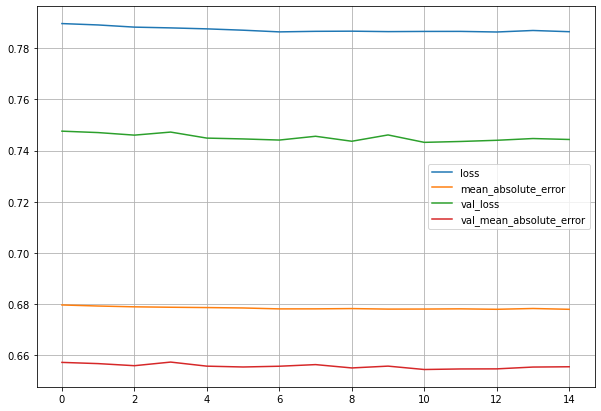

In [201]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)

plt.show()

### Should we train the model for more epochs?

##### As we can see on the graph, the validation and training error&loss are already almost parallel, they don't decrease much after increasing the epochs (sometimes they even increase a little). For that reason, the group thinks the **loss decrease / time spending training** ratio is too low to continue training for more epochs. Like we learned in classes, the model should be as light, as explainable and as easy to use as possible instead of having the best accuracy/least error.

### But why is your validation error inferior to the training error? Is there an error in our Neural Network?

##### NO! We use L2 regularization and Dropout regularization to help our model generalize better to data the NN has never seen. In other words, we use it to obtain higher validation/testing accuracy. **Regularization methods often sacrifice training accuracy** to improve validation/testing accuracy — **sometimes that leads to errors being inferior in the validation/test sets.**

### What does this error tell us?

##### The model, on average, has an error of ~0.65 in the ratings of movies. In our case, it means that if an user gives a 3.5 stars rating to a movie, on average, the model will probably predict that the user will give the film a rating between ~3 to ~4 stars.

In [220]:
model.save("recommendation_system.h5")

### Hyperparameters Fine-Tuning

The group tried different variations of the optimizer , learning rate, batch size and epochs through GridSearchCV. This code is not present in this notebook just because we want to keep it runnable and the Gridsearch takes a really long time to run. These were the optimal parameters we found:

- **Optimizer and Learning Rate**: After trying different optimizers with different learning rates, we found that the best optimizer was the Adam optimizer with a learning rate of 0.001 for this problem in specific.

- **Batch size**: the smaller the batch size, the smaller the error. However, we also prioritezed the time it took to run: the smaller the batch size, the higher the model needed to train. We reached the compromise of running a batch size of 1000.

- **Epochs**: Already discussed above. 

In [210]:
def predict_ratings(): 
    """Predicts the ratings and returns the real ratings of the films the users have already seen (the users and movies on the test set)

    Parameters
    ----------
    user : int
        The user_id of the user we want to checkout the ratings

    Returns
    ----------
    df : pandas.core.frame.DataFrame
        Returns a dataframe filtered by the user column
    """
    
    # Getting the y_predict from the test array
    y_proba = model.predict(full_X_test_array)
    y_proba = y_proba.round(2)
    
    # Putting everything in a dataframe: the user_id, the movie_id and the predicted and real rating the user has given to that film
    d = {'user': full_X_test_array[0], 'movie_id': full_X_test_array[1], 'predicted_rating': y_proba[:,0], 'real_rating': y_test}
    df = pd.DataFrame(data=d)
    return df

In [212]:
predict_ratings()

user  movie_id  predicted_rating  real_rating
0         35021      3945              3.23          3.0
1        112746      3732              2.43          2.0
2          1229        30              3.43          5.0
3        138449       362              2.49          3.0
4         33877      3276              4.27          4.0
...         ...       ...               ...          ...
2000022   68855      2676              4.14          4.0
2000023   93358      1694              1.57          0.5
2000024   91190      2286              3.75          5.0
2000025   29055       988              2.45          3.5
2000026   22288     11161              4.08          3.5

[2000027 rows x 4 columns]

#### The results of the model are satisfatory and they actually are inline with the Mean Absolute Error and MSE given, as expected.

In [213]:
def predict_ratings_user(user):
    """Predicts the ratings of the films the user has seen. The user_id has to be in the test set

    Parameters
    ----------
    user : int
        The user_id of the user we want to checkout the ratings. The user_id has to be in the test set

    Returns
    ----------
    df : pandas.core.frame.DataFrame
        Returns a dataframe filtered by the user column
    """
    # Getting the y_predict from the test array
    y_proba = model.predict(full_X_test_array)
    y_proba = y_proba.round(2)
    
    # Putting everything in a dataframe: the user_id, the movie_id and the predicted and real rating the user has given to that film
    d = {'user': full_X_test_array[0], 'movie_id': full_X_test_array[1], 'predicted_rating': y_proba[:,0], 'real_rating': y_test}
    df = pd.DataFrame(data=d)
    return df[df['user']==user]

In [215]:
predict_ratings_user(93358)

user  movie_id  predicted_rating  real_rating
32850    93358      1719              2.82          3.5
43746    93358      1242              3.84          3.0
68810    93358      4898              3.18          3.5
76211    93358      1588              3.10          3.5
87361    93358      9515              2.68          3.0
...        ...       ...               ...          ...
1941791  93358      5860              3.51          4.0
1946271  93358      9814              3.13          3.0
1955432  93358      1669              3.67          2.0
1981017  93358       834              2.34          3.0
2000023  93358      1694              1.57          0.5

[107 rows x 4 columns]

#### These are useful to compare the performance of the model in a real life situation, but it's not the finished product we wanted! What we want is to predict films a certain user has not watched yet!

#### We do that in the next function called **best_movies_by_user**: after inputting one user, **the function returns the respective predicted ratings for films that that user hasn't watched.**

In [252]:
def best_movies_by_user(user):
    """Predicts the best movie for a given user

    Parameters
    ----------
    user : int
        The user_id of the user we want to recommend a film.

    Returns
    ----------
    new_df : pandas.core.frame.DataFrame
        Returns a dataframe that only has films the user has not seen sorted by the predicted rating.
    """
    
    # Creating a new test set of all the films in the entire dataset and creating an array of the same size populated with the user_id
    X_movies = ratings['movie'].unique()
    X_user = np.full((1, len(X_movies)), user)

    # List with the two arrays
    user_predict = [X_user[0], X_movies]

    # Predicted film ratings
    y_proba = model.predict(user_predict)
    y_proba = y_proba.round(2)

    # Creating the data frame
    d = {'user': user_predict[0], 'movie_id': user_predict[1], 'predicted_rating': y_proba[:,0]}
    df = pd.DataFrame(data=d)

    # Adding to the dataframe the title of the movie
    movies_titles = ratings[['movie', 'title']]
    movies_titles=movies_titles.drop_duplicates()
    
    new_df = df.merge(movies_titles[['movie', 'title']], how = 'left',
                   left_on = 'movie_id', right_on = 'movie').drop(columns= ['movie'])

    # Creating a dataframe with movies that the user has already seen
    user_movies_rated = ratings[ratings['user']==user]
    user_movies_rated = user_movies_rated[['user', 'movie']]

    # Outter merging the user_movies_rated with the new_df to only recommend films that the user has not seen
    new_df = new_df.merge(user_movies_rated[['user', 'movie']], how='outer', left_on = 'movie_id', right_on = 'movie', indicator=True)
    new_df = new_df[new_df['_merge'] == 'left_only'].drop(columns= ['user_y', 'movie', '_merge'])
    new_df = new_df.rename(columns={'user_x': 'user'})
    
    # Returning the dataframe with the values sorted by the predicted rating
    return new_df.sort_values(by='predicted_rating', ascending=False).head(15)

In [254]:
best_movies_by_user(118204)

user  movie_id  predicted_rating  \
5265  118204     15188              4.15   
5267  118204     17015              4.14   
5269  118204     18939              4.14   
2807  118204     16916              4.11   
5475  118204      5591              4.10   
5337  118204      6873              4.09   
3812  118204       660              4.09   
9797  118204      5401              4.08   
4082  118204     18550              4.07   
5268  118204     18642              4.07   
2810  118204     17125              4.06   
2205  118204      2845              4.06   
2818  118204     17837              4.05   
8248  118204     18845              4.04   
9321  118204     22571              4.04   

                                                  title  
5265                                            Cosmos   
5267                             Louis C.K.: Hilarious   
5269                                      Black Mirror   
2807                                             Senna   
5475           Grave of the Fireflies (Hotaru no haka)   
5337  Passion of Joan of Arc, The (Passion de Jeanne...  
3812         Song of the Little Road (Pather Panchali)   
9797                               Red Beard (Akahige)   
4082            Louis C.K.: Live at the Beacon Theater   
5268                                    Civil War, The   
2810                                         Incendies   
2205              Time of the Gypsies (Dom za vesanje)   
2818           Separation, A (Jodaeiye Nader az Simin)   
8248                                     North & South   
9321                                                NaN

In [258]:
best_movies_by_user(46469)

user  movie_id  predicted_rating  \
2019  46469      1935              3.66   
1285  46469     10901              3.65   
1343  46469      1178              3.65   
456   46469       905              3.63   
7410  46469      6559              3.58   
245   46469       887              3.57   
5141  46469      8935              3.56   
3496  46469      3047              3.55   
2037  46469       909              3.54   
5265  46469     15188              3.53   
5338  46469      7421              3.53   
5269  46469     18939              3.53   
5260  46469      3220              3.53   
3978  46469      4912              3.52   
2416  46469      1186              3.52   

                                              title  
2019          Seven Samurai (Shichinin no samurai)   
1285  Lives of Others, The (Das leben der Anderen)   
1343                                  12 Angry Men   
456         Sunset Blvd. (a.k.a. Sunset Boulevard)   
7410                                         Ikiru   
245                                    Rear Window   
5141                      Decalogue, The (Dekalog)   
3496           Grand Illusion (La grande illusion)   
2037                                 All About Eve   
5265                                        Cosmos   
5338   Wages of Fear, The (Salaire de la peur, Le)   
5269                                  Black Mirror   
5260                                   City Lights   
3978                   Witness for the Prosecution   
2416                                Third Man, The

In [256]:
best_movies_by_user(125793)

user  movie_id  predicted_rating  \
3259  125793      1155              4.41   
5141  125793      8935              4.39   
5269  125793     18939              4.37   
3203  125793       661              4.37   
2037  125793       909              4.36   
184   125793       891              4.36   
6039  125793      7657              4.35   
2807  125793     16916              4.35   
8273  125793      7497              4.35   
4832  125793      8643              4.34   
4996  125793      1982              4.34   
3419  125793      2645              4.34   
7115  125793      9159              4.34   
4945  125793      8595              4.34   
2650  125793     18484              4.33   

                                         title  
3259                           Paths of Glory   
5141                 Decalogue, The (Dekalog)   
5269                             Black Mirror   
3203          World of Apu, The (Apur Sansar)   
2037                            All About Eve   
184                        North by Northwest   
6039            Sunrise: A Song of Two Humans   
2807                                    Senna   
8273       Virgin Spring, The (Jungfrukällan)   
4832           Andrei Rublev (Andrey Rublyov)   
4996                          Out of the Past   
3419  400 Blows, The (Les quatre cents coups)   
7115               From the Earth to the Moon   
4945                       Harakiri (Seppuku)   
2650                             Intouchables

# BEST MODEL

### No Model Solution - Positives, Limitations & Business Applications

- The No Model solution is based on the correlations between ratings, having no Machine Learning involved. This makes it more explainable and easier for any person in a company, for example, to adapt the solution to different contexts and make some slight changes.

- After comparing some of its recommendation with the IMDB recommendation system, the model seemed to actually have a nice performance: most of its recommendations based on a certain films were also recommendations from the IMDB for that film.

- The solution is good, but has its limitations: the model is an item-based (in this case, film-based) recommendation system: even though the group implemented a simple workaround that involves choosing the best rated film of a certain user and making the recommendation based only on that film, that solution still lacks a lot in terms of being a personalized recommendation system.

- Another important thing to mention is that it's difficult to evaluate it: unlike a real model, here we don't have a training and testing set, making it impossible for us to check if the user would actually like the movies recommended. This is a crucial part and a real setback when trying to understand if it should be implemented in a company or not. However, if the company wanted to do a test-run of this solution, it could use some of the evaluation metrics we learned in class, like the Hit-rate or Cumulative Hit Rate.

**BUSINESS APPLICATION** - The group still thinks this solution is a great film-based recommendation system and should be tested, maybe as a feature called **"If you liked this movie, maybe you should try...".**

### Neural Network - Positives, Limitations & Business Applications

- The Neural Nework actually gives us personalized recommendations, which was our end-goal all along.

- Although we win in personalized recommendations, we also lose a bit of explainability: it's more difficult to explain what actually happens and it's harder to explain to a person that doesn't know anything about Machine Learning or Neural Networks what is actually happening. **However, we think this problem was mitigated because the group provided various comments and explanations throughout this notebook that try to go step-by-step on what is actually happening and what are the variables and hyperparameters that can be changed.** This way, we think that the model can be explained to the higher-ups in the company and allow for business decisions to be taken. 

- Another thing that is important to mention is that the model takes a lot of time to be trained: in a normal computer, each epoch needs ~8 to ~11 minutes to run on the training and validation set. This contrasts with the previous No Model Solution, where the longest step in the process is creating the moviematrix variable.

- Unlike the No Model Solution, here we can evaluate the Neural Network performance on the training, validation and test set through the Mean Squared Error and Mean Absolute Error.

- One limitation of the model is that when we choose a user that has seen a reduced number of films and series (<20) the model actually gives similar recommendations to these users.

- There is about ~0.6 Mean Absolute Error in the Test Set, which was achieved with a simple Neural Network. We tried different combinations of hyperparameters and achieved what we thought was the best combination, but maybe someone with more experience in the NN field can go even further. It is important to notice, hovewer, that more complexity most of the times comes with less explainability, so we were actually happy with the present results.

- The model can be further refined and finetuned when its put into production and the results of metrics like the Cumulative Hit-rate are known.

**BUSINESS APPLICATION** - We would advise the company to implement this recommendation system as a feature called **"Recommended For You"**, as it narrows the user search times for a filme and leads to a better overall customer experience.

## FINAL CONCLUSION

The Neural Network model gives a more personalized experience and was actually evaluated, so we do think that is the strongest solution out of the two. However, we think both solutions can and should be used inside the same product: Netflix or Disney+, for example, can implement these recommendation systems in diffent sections like we said: one called **"If you liked this movie, maybe you should try...".** and another called **"Recommended For You"**. They are two different solutions that increase customer experience and give value-added to streaming services or even to films databases, like IMDB or Letterboxd, because they filter movies that the user will probably like while filtering out the ones that the user will most probably not like. These models can be even further finetuned with Hit-rate metrics, just like we learned in class.

In [ ]:
https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929

In [261]:
ratings_df = pd.read_csv('../../dataset/MovieLens_files/ratings.csv')

userId  movieId  rating   timestamp  \
0              1        2     3.5  1112486027   
1              5        2     3.0   851527569   
2             13        2     3.0   849082742   
3             29        2     3.0   835562174   
4             34        2     3.0   846509384   
...          ...      ...     ...         ...   
20000258  138301   121017     3.5  1420558479   
20000259  138301   121019     4.5  1420558606   
20000260  138301   121021     4.5  1420558687   
20000261  138406   110167     4.5  1396184127   
20000262  138406   110510     4.5  1397597539   

                                                      title  
0                                                  Jumanji   
1                                                  Jumanji   
2                                                  Jumanji   
3                                                  Jumanji   
4                                                  Jumanji   
...                                                     ...  
20000258                          The Gentleman from Epsom   
20000259                               The Great Spy Chase   
20000260                                   Taxi for Tobruk   
20000261  Judge and the Assassin, The (Juge et l'assassi...  
20000262                                       Série noire   

[20000263 rows x 5 columns]